In [1]:
import sys
sys.path.append("../../../../../py/")
sys.path.append("../")

In [2]:
import pickle as pk

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv

from patch_dataset import CLPatchDataset

In [3]:
with open("../../../../../py/output/patch_val_dataset_128.pk", "rb") as f:
    data = pk.load(f)

### YOLO

In [56]:
import os
import sys
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn

from models.common import DetectMultiBackend
from utils.augmentations import letterbox
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync

In [50]:
def dataset_from_list(img0_list, img_size, stride, auto):
    dataset = []
    
    for img0 in img0_list:
        img = letterbox(img0, img_size, stride=stride, auto=auto)[0]
        img = img.transpose((2, 0, 1))  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)
        dataset.append(("", img, img0, None, "")) 
    
    return dataset

In [57]:
@torch.no_grad()
def yolo_predict(weights,
        source,# file/dir/URL/glob, 0 for webcam
        imgsz=640,  # inference size (pixels)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device="cpu",  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project="runs/detect",  # save results to project/name
        name="exp",  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=3,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        dataset=None
        ):    
    
        source = str(source)
        save_img = not nosave and not source.endswith('.txt')  # save inference images
        print("save_img",save_img)
        is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)

        if is_file:
            source = check_file(source)  # download

        # Directories
        if not nosave:
            save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
            (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

        # Load model
        device = select_device(device)
        model = DetectMultiBackend(weights, device=device, dnn=dnn)
        stride, names, pt, jit, onnx = model.stride, model.names, model.pt, model.jit, model.onnx
        imgsz = check_img_size(imgsz, s=stride)  # check image size

        # Half
        half &= pt and device.type != 'cpu'  # half precision only supported by PyTorch on CUDA
        if pt:
            model.model.half() if half else model.model.float()

        # Dataloader
        if dataset is None:
            dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt and not jit)
        else:
            dataset = dataset_from_list(dataset, img_size=imgsz, stride=stride, auto=pt and not jit)

        # Run inference
        if pt and device.type != 'cpu':
            model(torch.zeros(1, 3, *imgsz).to(device).type_as(next(model.model.parameters())))  # warmup
        dt, seen = [0.0, 0.0, 0.0], 0
        
        results = []
        
        for path, im, im0s, _, s in dataset:
            
            t1 = time_sync()
            im = torch.from_numpy(im).to(device)
            im = im.half() if half else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim
            t2 = time_sync()
            dt[0] += t2 - t1

            # Inference

            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(im, augment=augment, visualize=visualize)
            t3 = time_sync()
            dt[1] += t3 - t2

            # NMS
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
            dt[2] += time_sync() - t3

            # Second-stage classifier (optional)
            # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

            # Process predictions
            for i, det in enumerate(pred):  # per image
                result = []
                seen += 1
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
                
                if not nosave:
                    save_path = str(save_dir / p.name)  # im.jpg
                    print(save_dir,p.name,save_path)
                    txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
                s += '%gx%g ' % im.shape[2:]  # print string
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
                imc = im0.copy() if save_crop else im0  # for save_crop
                annotator = Annotator(im0, line_width=line_thickness, example=str(names))
                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class
                        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # Write results
                    for *xyxy, conf, cls in reversed(det):
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls.item(), *xywh, conf.item()) if save_conf else (cls.item(), *xywh)  # label format
                        result.append(line)
                        if save_txt and not nosave:  # Write to file
                            with open(txt_path + '.txt', 'a') as f:
                                f.write(('%g ' * len(line)).rstrip() % line + '\n')

                # Print time (inference-only)
                LOGGER.info(f'{s}Done. ({t3 - t2:.3f}s)')

            results.append(result)
            
        return results

In [58]:
idx = [1142, 493, 12, 190]
dataset = [data.X_1[i].patch for i in idx]

In [59]:
bboxes = yolo_predict(weights = "train/exp8/weights/best.pt",
                      source = "tree_pics/X_1_1142.png",
                      imgsz = 640,
                      save_conf = True,
                      device = "cpu",
                      save_txt = False,
                      nosave = True,
                      classes = 2,
                      dataset = dataset)
                      

16-03-2023 10:30:33 INFO YOLO 🚀 2022-4-4 torch 1.9.1 CPU



save_img False


16-03-2023 10:30:34 INFO Fusing layers... 
16-03-2023 10:30:36 INFO Model Summary: 392 layers, 46611336 parameters, 0 gradients, 114.0 GFLOPs
16-03-2023 10:30:39 INFO 640x640 5 trees, Done. (2.786s)
16-03-2023 10:30:41 INFO 640x640 5 trees, Done. (2.590s)
16-03-2023 10:30:44 INFO 640x640 5 trees, Done. (2.287s)
16-03-2023 10:30:46 INFO 640x640 1 tree, Done. (2.275s)


In [41]:
bboxes

[[(2.0, 0.0546875, 0.984375, 0.09375, 0.03125, 0.6081590056419373),
  (2.0, 0.10546875, 0.7890625, 0.0859375, 0.078125, 0.6483353972434998),
  (2.0, 0.14453125, 0.96875, 0.0859375, 0.0625, 0.7314712405204773),
  (2.0, 0.09375, 0.67578125, 0.078125, 0.0703125, 0.7421197295188904),
  (2.0, 0.08984375, 0.890625, 0.0859375, 0.078125, 0.7598377466201782)]]

In [60]:
bboxes

[[(2.0, 0.0546875, 0.984375, 0.09375, 0.03125, 0.6081590056419373),
  (2.0, 0.10546875, 0.7890625, 0.0859375, 0.078125, 0.6483353972434998),
  (2.0, 0.14453125, 0.96875, 0.0859375, 0.0625, 0.7314712405204773),
  (2.0, 0.09375, 0.67578125, 0.078125, 0.0703125, 0.7421197295188904),
  (2.0, 0.08984375, 0.890625, 0.0859375, 0.078125, 0.7598377466201782)],
 [(2.0, 0.13671875, 0.92578125, 0.1484375, 0.1328125, 0.4728267788887024),
  (2.0, 0.4453125, 0.66015625, 0.09375, 0.0703125, 0.56662517786026),
  (2.0, 0.41796875, 0.76171875, 0.1328125, 0.1171875, 0.7558351159095764),
  (2.0, 0.44140625, 0.35546875, 0.1328125, 0.1171875, 0.7709850668907166),
  (2.0, 0.671875, 0.54296875, 0.125, 0.1171875, 0.8033538460731506)],
 [(2.0, 0.76953125, 0.04296875, 0.1171875, 0.0859375, 0.5680012106895447),
  (2.0, 0.375, 0.19921875, 0.140625, 0.1171875, 0.72325599193573),
  (2.0, 0.19140625, 0.296875, 0.1328125, 0.125, 0.7654269933700562),
  (2.0, 0.63671875, 0.09765625, 0.1328125, 0.1328125, 0.77186048030853

In [9]:
for i in idx:
    img1 = data.X_1[i].patch
    img2 = data.X_2[i].patch
    
    Image.fromarray(img1).save(f"tree_pics/X_1_{i}.png")
    Image.fromarray(img2).save(f"tree_pics/X_2_{i}.png")

In [26]:
def get_img_bbox(img, bboxes, c):
    image_width = img.shape[0]
    
    bbox_img = img.copy()
    
    if isinstance(bboxes, str) and bboxes.endswith(".txt"):
        with open(bboxes, "r") as f:
            lines = f.readlines()

        tokens = [[float(token) for token in line.split()] for line in lines]
    else:
        tokens = bboxes
    
    img_tokens = []
    
    for token in tokens:
        # Parse the prediction values
        class_id, x_center, y_center, width, height, *rest = token
        
        if c is None or c == class_id:
            # Convert the normalized coordinates to pixel coordinates
            x_min = int((x_center - (width / 2)) * image_width)
            y_min = int((y_center - (height / 2)) * image_width)
            x_max = int((x_center + (width / 2)) * image_width)
            y_max = int((y_center + (height / 2)) * image_width)

            # Draw the bounding box rectangle on the image
            cv.rectangle(bbox_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness=1)
        
    return bbox_img

In [28]:
img = data.X_1[1142].patch

In [31]:
bbox_img = get_img_bbox(img, bboxes[0], c = 2)

In [32]:
bbox_img_txt = get_img_bbox(img, "detect/exp25/labels/X_1_1142.txt", c = 2)

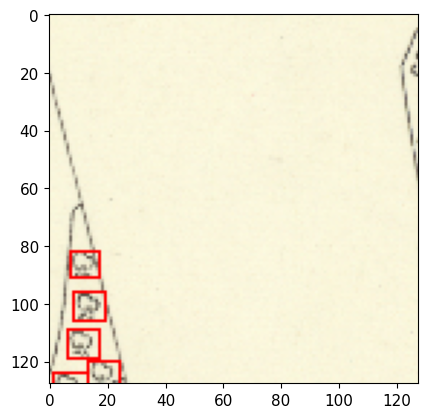

In [33]:
fig, ax = plt.subplots()
ax.imshow(bbox_img)
plt.show()

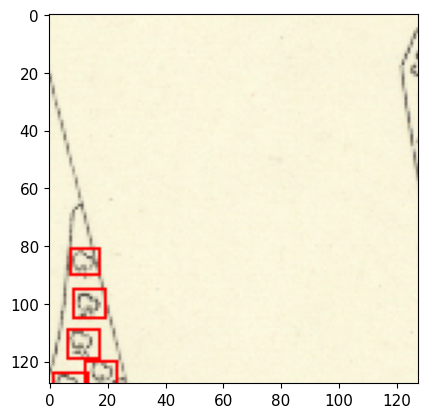

In [34]:
fig, ax = plt.subplots()
ax.imshow(bbox_img_txt)
plt.show()

In [65]:
len(bboxes)

4

In [64]:
idx

[1142, 493, 12, 190]

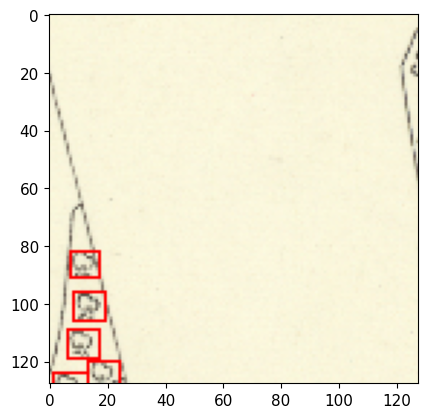

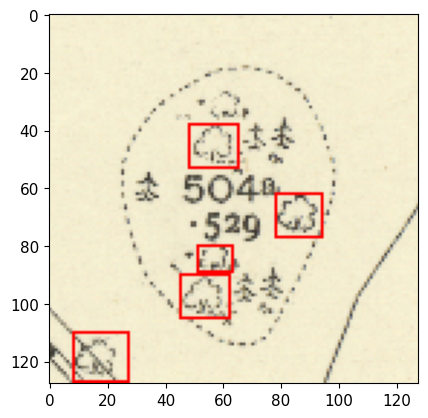

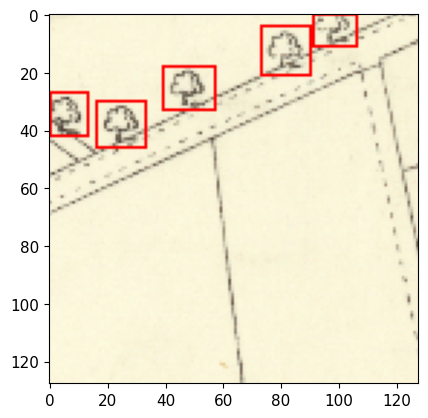

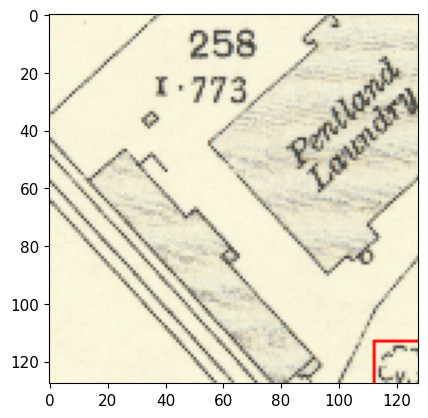

In [66]:
for j,i in enumerate(idx):
    img = data.X_1[i].patch
    bbox_img = get_img_bbox(img, bboxes[j], c = 2)
    
    fig, ax = plt.subplots()
    ax.imshow(bbox_img)
    plt.show()

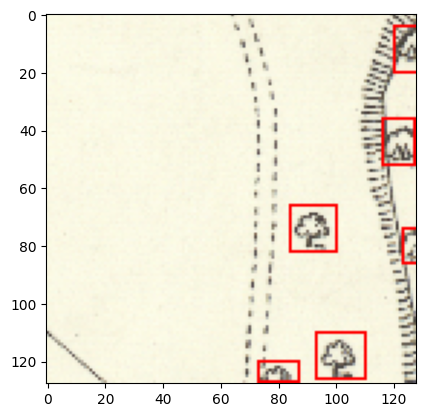

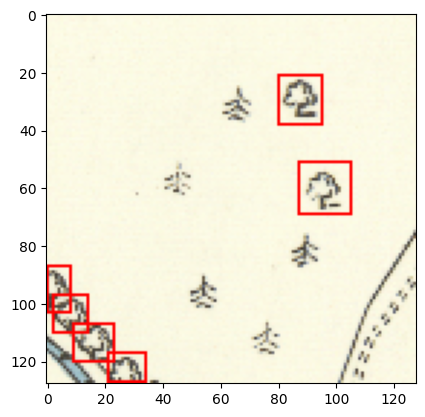

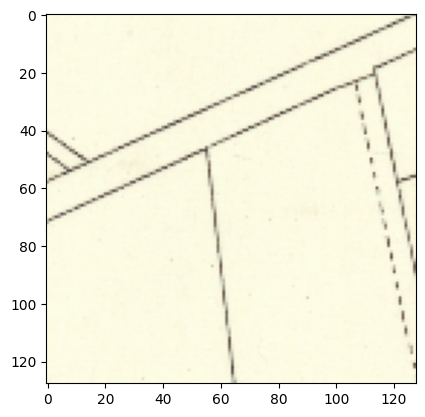

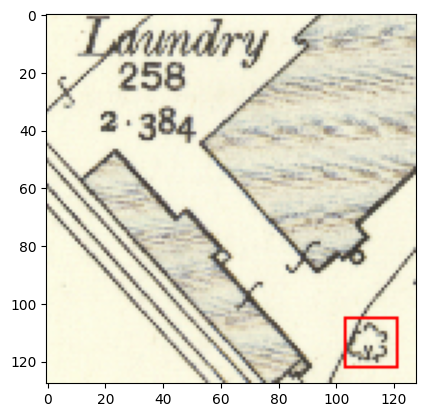

In [36]:
for i in idx:
    img = data.X_2[i].patch
    bbox_img = get_img_bbox(img, f"detect/exp25/labels/X_2_{i}.txt", c = 2)
    
    fig, ax = plt.subplots()
    ax.imshow(bbox_img)
    plt.show()